In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

## Load Data

In [5]:
df = pd.read_csv('dataset/DTW_to_MIA.csv')

In [6]:
df.shape

(289413, 28)

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 289413 entries, 0 to 289412
Data columns (total 28 columns):
 #   Column                             Non-Null Count   Dtype  
---  ------                             --------------   -----  
 0   Unnamed: 0                         289413 non-null  int64  
 1   legId                              289413 non-null  object 
 2   searchDate                         289413 non-null  object 
 3   flightDate                         289413 non-null  object 
 4   startingAirport                    289413 non-null  object 
 5   destinationAirport                 289413 non-null  object 
 6   fareBasisCode                      289413 non-null  object 
 7   travelDuration                     289413 non-null  object 
 8   elapsedDays                        289413 non-null  int64  
 9   isBasicEconomy                     289413 non-null  bool   
 10  isRefundable                       289413 non-null  bool   
 11  isNonStop                          2894

In [8]:
# only focus on nonstop flights and pick useful columns
df = df[df['isNonStop'] == True]
df = df.iloc[:,[2,3,7,8,9,10,12,14,15,17,19,22,24,27]]

In [9]:
# totalTravelDistance and isRefundable variables have no variance, so remove this column
print(df['totalTravelDistance'].value_counts())
print(df['isRefundable'].value_counts())
df.drop(['totalTravelDistance','isRefundable'], axis=1, inplace=True)
# Arrival time is decided by departure time and travel duration so it is redundant, remove it
df.drop(['segmentsArrivalTimeRaw'], axis=1, inplace=True)
# Drop first class cabin
df = df[df['segmentsCabinCode'] != 'first']
df.drop(['segmentsCabinCode'], axis=1, inplace=True)

1153.0    23727
Name: totalTravelDistance, dtype: int64
False    40131
Name: isRefundable, dtype: int64


In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 40116 entries, 2 to 289412
Data columns (total 10 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   searchDate                    40116 non-null  object 
 1   flightDate                    40116 non-null  object 
 2   travelDuration                40116 non-null  object 
 3   elapsedDays                   40116 non-null  int64  
 4   isBasicEconomy                40116 non-null  bool   
 5   baseFare                      40116 non-null  float64
 6   seatsRemaining                40116 non-null  int64  
 7   segmentsDepartureTimeRaw      40116 non-null  object 
 8   segmentsAirlineName           40116 non-null  object 
 9   segmentsEquipmentDescription  39741 non-null  object 
dtypes: bool(1), float64(1), int64(2), object(6)
memory usage: 3.1+ MB


## Deal with Missing Data

In [11]:
df.isna().sum()

searchDate                        0
flightDate                        0
travelDuration                    0
elapsedDays                       0
isBasicEconomy                    0
baseFare                          0
seatsRemaining                    0
segmentsDepartureTimeRaw          0
segmentsAirlineName               0
segmentsEquipmentDescription    375
dtype: int64

In [12]:
# remove the rows with missing values
df = df.dropna()

## Change the Format of Some Variables

In [13]:
#travelDuration to hours
dates = []
for date in df['travelDuration'].values:
    if date[4:-1] != '':
        dates.append(int(date[2]) + round(float(date[4:-1])/60,1))
    else:
        dates.append(int(date[2]))
df['travelDuration'] = dates

In [14]:
# change flightDate to Date type
df['flightDate'] = pd.to_datetime(df['flightDate'])

In [15]:
# change searchDate to the days before flight days
df['searchDaysBeforeDepartue'] = (df['flightDate']-pd.to_datetime(df['searchDate'])).dt.days.astype(int)
df.drop(['searchDate'], axis=1, inplace=True)

In [16]:
# convert flightDate to the weekday 
df['flightDay'] = df['flightDate'].dt.day_name()
df.drop(['flightDate'], axis=1, inplace=True)

In [17]:
# change segmentsDepartureTimeRaw to four time categories
time_category = []
for date in df['segmentsDepartureTimeRaw'].values:
    time = int(date[11:13])
    if time >= 0 and time < 6:
        time_category.append('Night')
    elif time >= 6 and time < 12:
        time_category.append('Morning')
    elif time >=12 and time < 18:
        time_category.append('Afternoon')
    else:
        time_category.append('Evening')
df['departureTime'] = time_category
df.drop(['segmentsDepartureTimeRaw'], axis=1, inplace=True)

In [18]:
# rename some variables
df = df.rename(columns={"segmentsAirlineName": "airlineName", "segmentsEquipmentDescription": "equipmentDescription"})

In [19]:
df.head()

,travelDuration,elapsedDays,isBasicEconomy,baseFare,seatsRemaining,airlineName,equipmentDescription,searchDaysBeforeDepartue,flightDay,departureTime
2,3.1,0,False,140.00,0,Spirit Airlines,AIRBUS INDUSTRIE A321 SHARKLETS,1,Sunday,Morning
3,3.0,0,False,262.33,2,Delta,Boeing 737-900,1,Sunday,Afternoon
4,3.0,0,False,262.33,7,Delta,Airbus A321,1,Sunday,Morning
5,3.1,0,False,262.33,7,American Airlines,Embraer 175,1,Sunday,Afternoon
6,3.1,0,False,262.33,7,American Airlines,Boeing 737-800,1,Sunday,Morning


In [20]:
df.shape

(39741, 10)

## Drop Spirit Rows

In [21]:
df = df[~df.airlineName.str.match('Spirit')]

In [22]:
df.shape

(23846, 10)

In [23]:
# Drop elapsedDays column as it has no variance
df.drop(['elapsedDays'], axis=1, inplace=True)

## Remove Outliers 

In [24]:
# remove outliers in the response baseFare
from scipy import stats
df = df[(np.abs(stats.zscore(df['baseFare'])) < 3)]

In [25]:
df.shape

(23574, 9)

## EDA

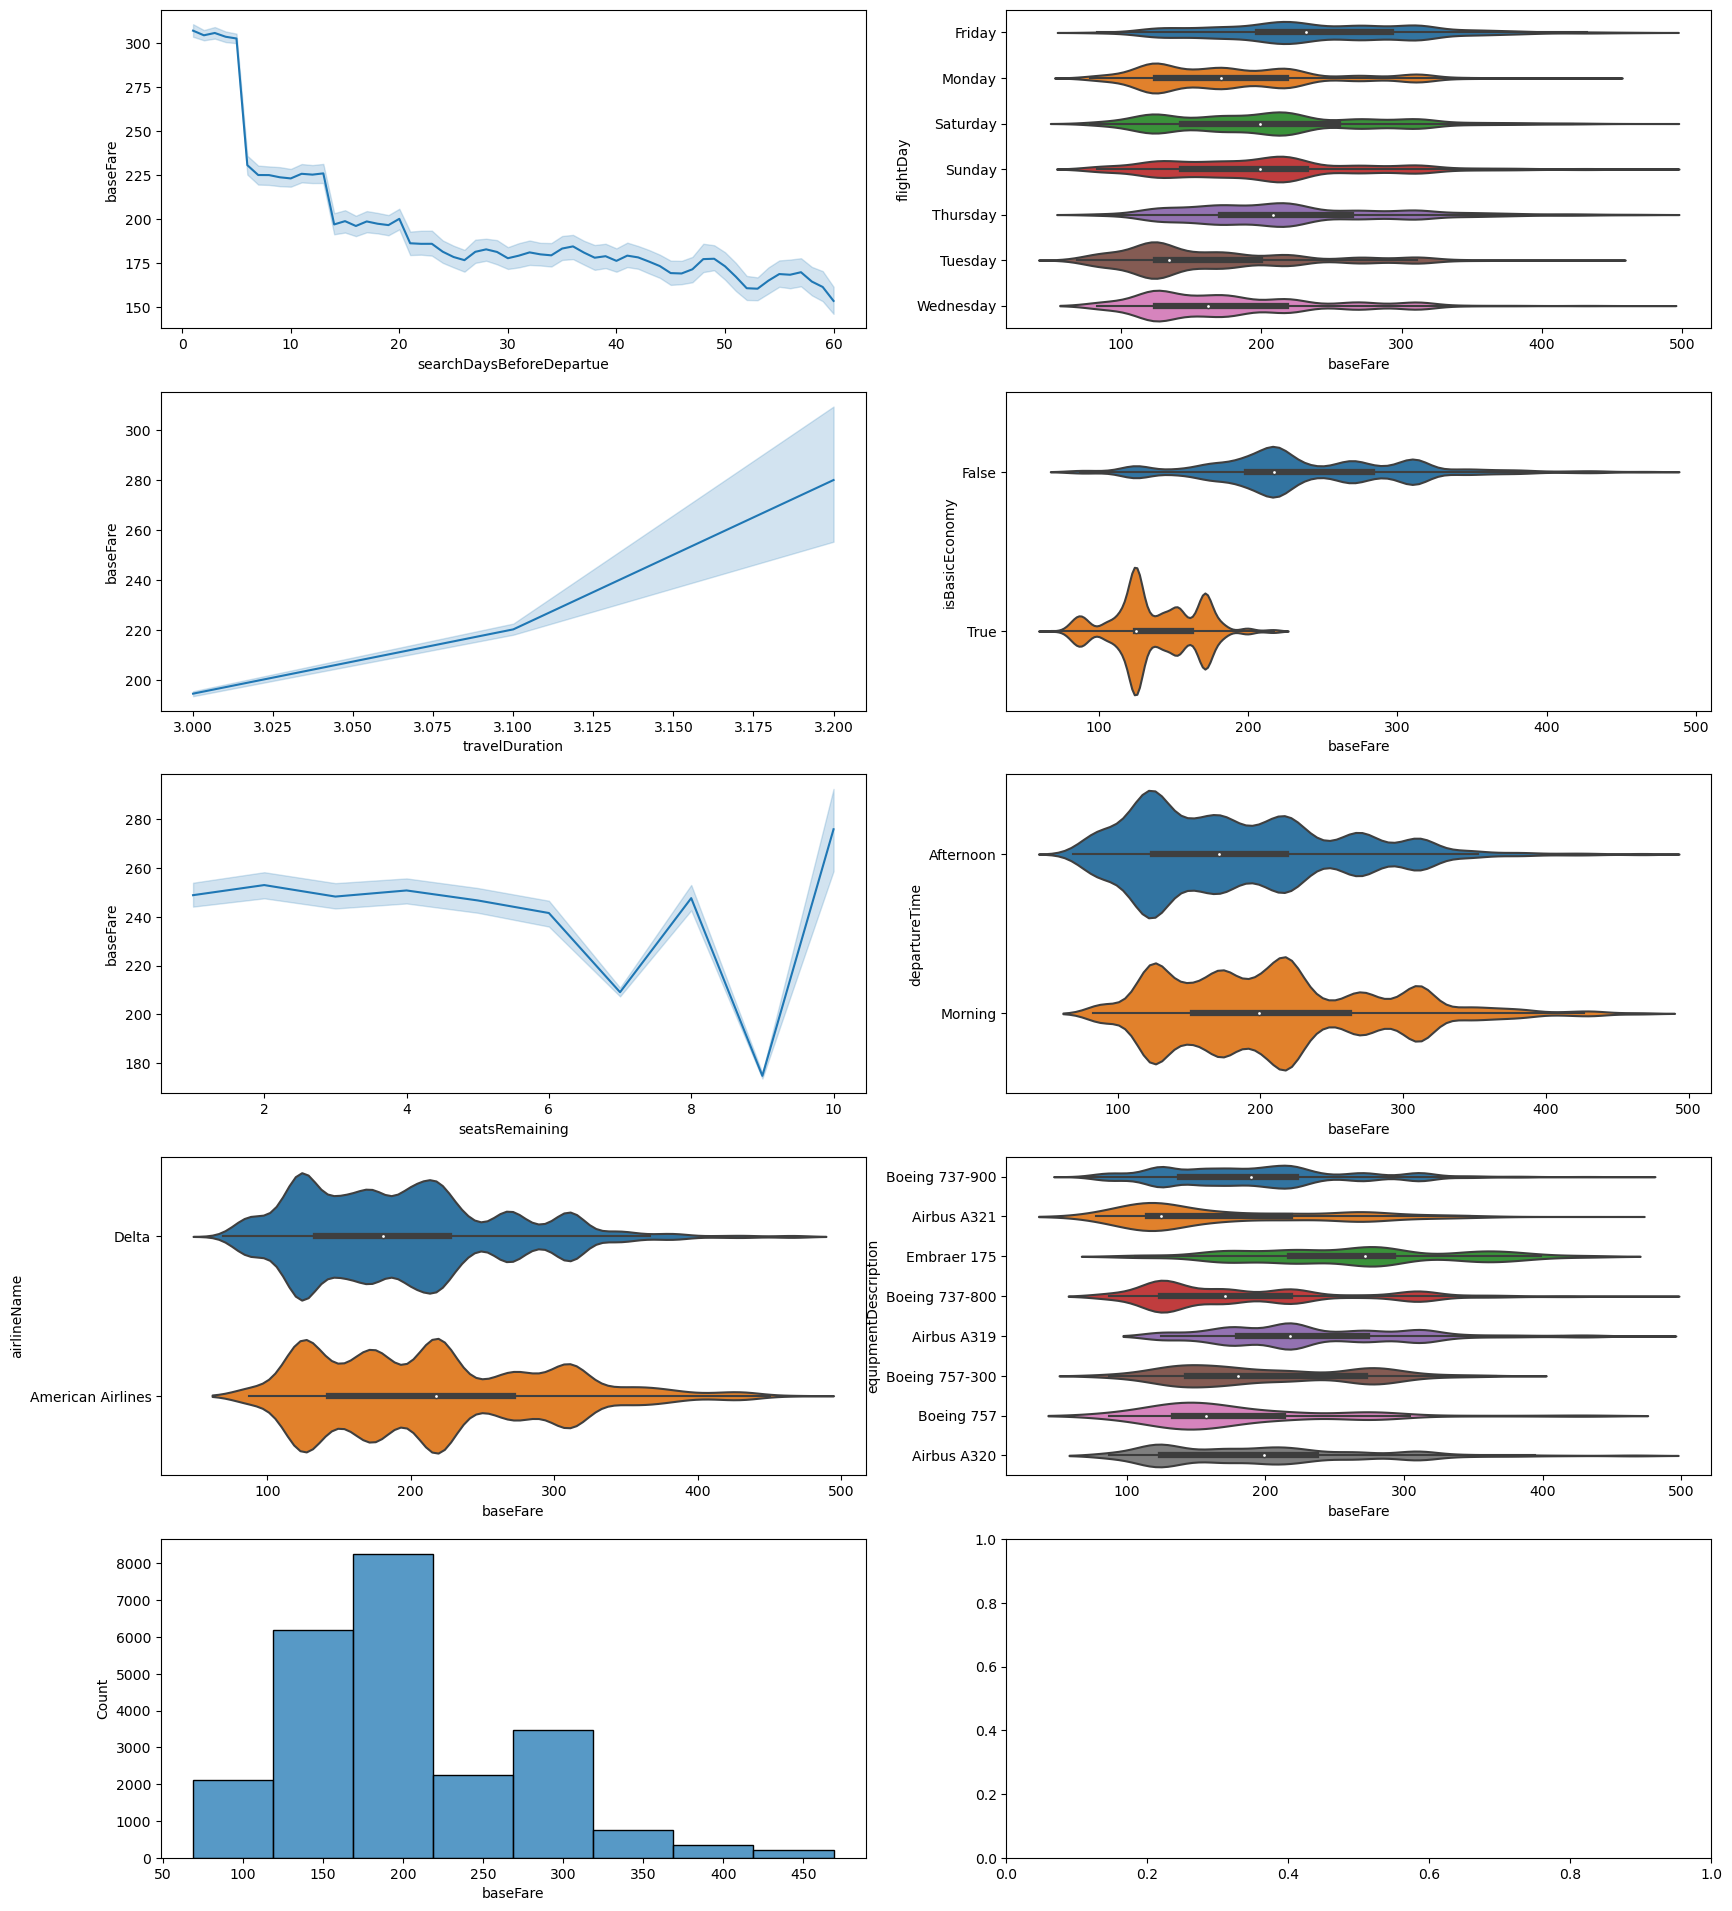

In [31]:
fig, axes = plt.subplots(5,2, figsize=(20,24))
sns.lineplot(ax=axes[0,0], x=df['searchDaysBeforeDepartue'], y=df['baseFare'])
sns.violinplot(ax=axes[0,1], y=df['flightDay'].astype('category'), x=df['baseFare'])
sns.lineplot(ax=axes[1,0], x=df['travelDuration'], y=df['baseFare'])
sns.violinplot(ax=axes[1,1], y=df['isBasicEconomy'].astype('category'), x=df['baseFare'])
sns.lineplot(ax=axes[2,0], x=df['seatsRemaining'].astype('category'), y=df['baseFare'])
sns.violinplot(ax=axes[2,1], y=df['departureTime'].astype('category'), x=df['baseFare'])
sns.violinplot(ax=axes[3,0], y=df['airlineName'], x=df['baseFare'])
sns.violinplot(ax=axes[3,1], y=df['equipmentDescription'], x=df['baseFare'])
sns.histplot(ax=axes[4,0], x=df['baseFare'], binwidth=50)
plt.savefig("EDA.png")
plt.show()

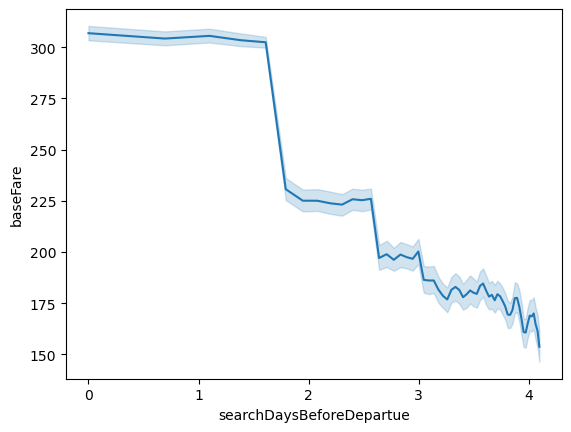

In [32]:
sns.lineplot(x=np.log(df['searchDaysBeforeDepartue']), y=df['baseFare'])
plt.show()

## Variable Transformation and Simplification

In [33]:
# Transform searchDaysBeforeDeparture variable to log scale
df.loc[:,'searchDaysBeforeDepartue'] = round(np.log(df.loc[:,'searchDaysBeforeDepartue']),2)
df = df.rename(columns={'searchDaysBeforeDepartue': 'searchDaysBeforeDepartueLog'})

In [34]:
# For simplicity, combine some categories in the equipment description variable
df = df.replace(regex=r'Airbus A319', value=0)
df = df.replace(regex=r'^Embraer.*', value=0)
df = df.replace(regex=r'Airbus.*', value=1)
df = df.replace(regex=r'Boeing.*', value=1)

In [35]:
# Combine some categories in flightDay variable
df = df.replace({'flightDay': {'Monday':0, 'Tuesday':1, 'Wednesday':1, 'Thursday':0, 
                         'Friday':0, 'Saturday':0, 'Sunday':0}})

## One-Hot Encoding

In [36]:
from sklearn.preprocessing import OneHotEncoder
from scipy.sparse import csr_matrix
categorical_column = ['isBasicEconomy', 'airlineName', 'departureTime', 'equipmentDescription', 'flightDay']
enc = OneHotEncoder(drop='first')
df[categorical_column[:]] = csr_matrix.toarray(enc.fit_transform(df.loc[:,categorical_column[:]]))

In [37]:
df = df.rename(columns={'airlineName':'isDelta', 'departureTime':'isDepartureMorning', 
                        'equipmentDescription': 'isEquipmentOther','flightDay':'isFlightTueWed'})

In [38]:
df.head()

,travelDuration,isBasicEconomy,baseFare,seatsRemaining,isDelta,isEquipmentOther,searchDaysBeforeDepartueLog,isFlightTueWed,isDepartureMorning
3,3.0,0.0,262.33,2,1.0,1.0,0.00,0.0,0.0
4,3.0,0.0,262.33,7,1.0,1.0,0.00,0.0,1.0
5,3.1,0.0,262.33,7,0.0,0.0,0.00,0.0,0.0
6,3.1,0.0,262.33,7,0.0,1.0,0.00,0.0,1.0
40,3.0,0.0,262.33,9,1.0,1.0,0.69,0.0,0.0


In [39]:
df.describe()

,travelDuration,isBasicEconomy,baseFare,seatsRemaining,isDelta,isEquipmentOther,searchDaysBeforeDepartueLog,isFlightTueWed,isDepartureMorning
count,23574.000000,23574.000000,23574.000000,23574.000000,23574.000000,23574.000000,23574.000000,23574.000000,23574.000000
mean,3.022542,0.370620,200.546469,7.325910,0.646602,0.813651,3.002053,0.240816,0.704081
std,0.042481,0.482981,74.304410,2.237491,0.478035,0.389397,0.912279,0.427588,0.456465
min,3.000000,0.000000,68.840000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,3.000000,0.000000,133.950000,7.000000,0.000000,1.000000,2.560000,0.000000,0.000000
50%,3.000000,0.000000,199.070000,9.000000,1.000000,1.000000,3.260000,0.000000,1.000000
75%,3.000000,1.000000,236.280000,9.000000,1.000000,1.000000,3.690000,0.000000,1.000000
max,3.200000,1.000000,468.840000,10.000000,1.000000,1.000000,4.090000,1.000000,1.000000


## Check covariance

In [30]:
df.corr()

,travelDuration,isBasicEconomy,baseFare,seatsRemaining,isDelta,isEquipmentOther,searchDaysBeforeDepartueLog,isFlightTueWed,isDepartureMorning
travelDuration,1.000000,-0.073703,0.152598,-0.133528,-0.284942,-0.274843,0.000043,-0.037529,-0.113427
isBasicEconomy,-0.073703,1.000000,-0.649515,0.475319,0.335987,0.367243,0.304701,0.124068,-0.269493
baseFare,0.152598,-0.649515,1.000000,-0.348048,-0.132986,-0.250380,-0.504803,-0.223396,0.159666
seatsRemaining,-0.133528,0.475319,-0.348048,1.000000,0.357471,0.315005,0.193916,0.083085,-0.221983
isDelta,-0.284942,0.335987,-0.132986,0.357471,1.000000,0.644376,0.008610,-0.081721,-0.448563
isEquipmentOther,-0.274843,0.367243,-0.250380,0.315005,0.644376,1.000000,0.063004,-0.041299,-0.272547
searchDaysBeforeDepartueLog,0.000043,0.304701,-0.504803,0.193916,0.008610,0.063004,1.000000,-0.011023,0.025956
isFlightTueWed,-0.037529,0.124068,-0.223396,0.083085,-0.081721,-0.041299,-0.011023,1.000000,0.166038
isDepartureMorning,-0.113427,-0.269493,0.159666,-0.221983,-0.448563,-0.272547,0.025956,0.166038,1.000000


## Train test split

In [31]:
from sklearn.model_selection import train_test_split
X = df.drop(['baseFare'],axis=1)
y = df.loc[:,['baseFare']]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=551)

In [32]:
X_train.to_csv('X_train.csv')
X_test.to_csv('X_test.csv')
y_train.to_csv('y_train.csv')
y_test.to_csv('y_test.csv')